In [4]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

/home/pushpendra/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def unet(pretrained_weights = None,input_size = (96,96,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [6]:
import SimpleITK as sitk
import os
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def find_images(path_dir):
    num=30
    X_train=np.zeros((274*num,96,96),dtype=np.uint16)
    Y_train=np.zeros((274*num,96,96),dtype=np.uint16)
    j=0
    k=0
    for item in os.listdir(path_dir):
        item=os.path.join(path_dir,item)
        for item2 in os.listdir(item):
            im ={'T1':None,'gt':None}
            item2=os.path.join(item,item2)
            for item3 in os.listdir(item2):
                item3=os.path.join(item2,item3)
                for item4 in os.listdir(item3):
                    item5=os.path.join(item3,item4)
                    if os.path.isfile(item5) and item5.endswith('.mha'):
                        itk_image = sitk.ReadImage(item5)
                        nd_image = sitk.GetArrayFromImage(itk_image)
                        if 'more' in item5 or 'OT' in item5:
                            im['gt']=nd_image
                        elif 'T1' in item5:
                            im['T1']=nd_image
            for i in range(90,90+num):
                Y_train[j]=np.where(im['gt'][i,24:216:2,24:216:2] > 0, 1, 0)
                X_train[j]=im['T1'][i,24:216:2,24:216:2]
                j+=1
            k+=1
            if k==2:
                break
    return X_train,Y_train

In [10]:
path_dir="/media/pushpendra/DATA/4th sem/AML/assignment1/BRATS2015_Training"

In [13]:
X_train,Y_train=find_images(path_dir)
X1_train=X_train/np.amax(X_train)
#Y1_train=Y_train-np.mean(Y_train,axis=0)
shape=X1_train.shape
X1_train=X1_train.reshape(shape[0],shape[1],shape[2],1)
Y_train=Y_train.reshape(shape[0],shape[1],shape[2],1)


In [16]:
model = unet(input_size = (96,96,1))
model_checkpoint = ModelCheckpoint('unet_brat.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(X1_train, Y_train, batch_size=2, nb_epoch=2, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

/home/pushpendra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/home/pushpendra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 96, 96, 64)   640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 96, 96, 64)   36928       conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 48, 48, 64)   0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 

Train on 6576 samples, validate on 1644 samples
Epoch 1/2
1950/6576 [=======>......................] - ETA: 1:17:50 - loss: 0.1337 - acc: 0.9920

KeyboardInterrupt: 

In [1]:
412+530

942

In [6]:
from PIL import Image

(227, 227)


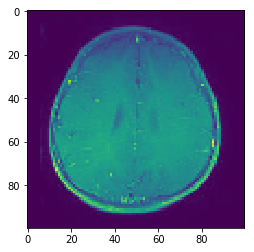

In [25]:
img = Image.open("/media/pushpendra/DATA/4th sem/AML/assignment1/normalsVsAbnormalsV1/normalsJPG/IMG-0001-00001.jpg").convert('L')

# img= img.resize((113,113),Image.ANTIALIAS)

a = np.asarray(img)
print(a.shape)
#a.reshape(240,240,1)
# plt.imshow(a)
plt.imshow(a[13:213:2,13:213:2])

In [7]:
def find_test_images(path_dir):
    X_test=np.zeros((942,96,96),dtype=np.uint16)
    Y_test=np.zeros((942,2),dtype=np.uint16)
    j=0
    k=1
    for item in os.listdir(path_dir):
        item=os.path.join(path_dir,item)
        for item2 in os.listdir(item):
            item5=os.path.join(item,item2)
            if os.path.isfile(item5) and item5.endswith('.jpg'):
                image = Image.open(item5).convert('L')
                image = image.resize((96,96),Image.ANTIALIAS)
                X_test[j]=image
                Y_test[j][k]=1
                j+=1
        k-=1
    return X_test,Y_test

In [61]:
test_path="/media/pushpendra/DATA/4th sem/AML/assignment1/normalsVsAbnormalsV1"
X_test,Y_test = find_test_images(test_path)

In [76]:
X_train=X_train-mean

In [54]:
np.save("mean",np.mean(X_test,axis=0))

In [75]:

mean = np.load("mean.npy")

In [77]:
shape=X_train.shape
X_train=X_train.reshape(shape[0],shape[1],shape[2],1)

In [81]:
model = unet()
model.load_weights("unet_brat.hdf5")
results = model.predict(X_test[0:100,:,:,:],30,verbose=1)

/home/pushpendra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_193 (Conv2D)             (None, 96, 96, 64)   640         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 96, 96, 64)   36928       conv2d_193[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_33 (MaxPooling2D) (None, 48, 48, 64)   0           conv2d_194[0][0]                 
__________________________________________________________________________________________________
conv2d_195

100/100 [==============================] - 22s 217ms/step


In [69]:
results.shape

(100, 96, 96, 1)

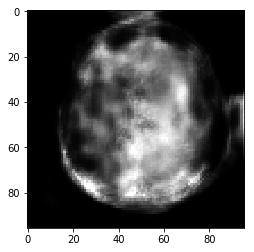

In [98]:
plt.imshow(results[40].reshape(96,96),cmap='gray')

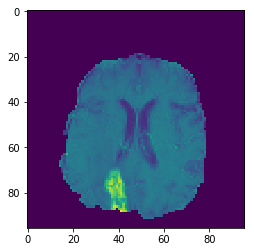

In [97]:
plt.imshow(X_train[40].reshape(96,96))

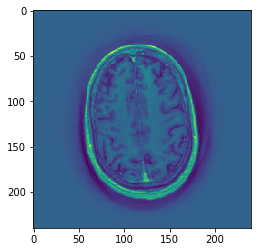

In [12]:
plt.imshow(X_test[6]-np.mean(X_test,axis=0))

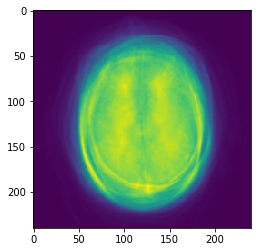

In [13]:
plt.imshow(np.mean(X_test,axis=0))

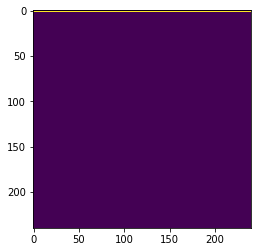

In [14]:
plt.imshow(Y_test[10].reshape(240,240))

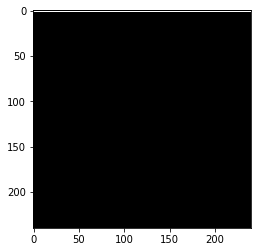

In [15]:
plt.imshow(np.where(Y_test[10] > 0, 1, 0).reshape(240,240), cmap='gray')

In [16]:
np.where(Y_test[10] > 0, 1, 0)

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
results[6].reshape(240,240)

array([[2.8083616e-06, 3.7716855e-08, 1.5063185e-10, ..., 3.1924164e-01,
        4.6423692e-01, 5.0010830e-01],
       [1.1212572e-26, 1.8443907e-36, 0.0000000e+00, ..., 5.9769403e-02,
        2.6437232e-01, 5.0010830e-01],
       [1.9541143e-30, 2.5107005e-32, 1.0845013e-36, ..., 6.3027225e-02,
        2.2165236e-01, 5.0010830e-01],
       ...,
       [7.6972097e-25, 1.5591382e-31, 0.0000000e+00, ..., 1.8881363e-01,
        3.4437606e-01, 4.3743277e-01],
       [1.1962831e-13, 8.4903741e-19, 7.5460697e-22, ..., 3.6562890e-01,
        4.5043856e-01, 4.7494373e-01],
       [2.0040283e-05, 4.8704940e-10, 6.1618474e-11, ..., 4.9407321e-01,
        4.9575043e-01, 4.6239892e-01]], dtype=float32)

In [39]:
import nibabel as nib
img = nib.load("../nii/002_brain.nii.gz")

In [40]:
data=img.get_fdata()

In [41]:
data.shape

(256, 256, 150)

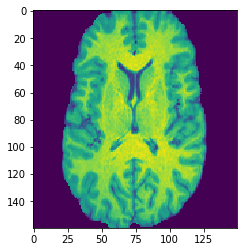

In [58]:
plt.imshow(data[50:210,140,:])

In [59]:
from skimage.transform import resize

# image = color.rgb2gray(data.astronaut())

# image_rescaled = rescale(image, 1.0 / 4.0, anti_aliasing=False)
image_resized = resize(data[50:210,140,:], (240, 240))

/home/pushpendra/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


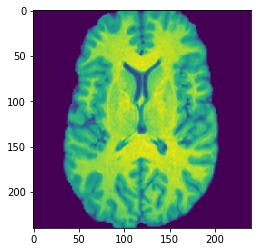

In [60]:
plt.imshow(image_resized)

In [61]:
image_resized.shape

(240, 240)

In [3]:
epoch_frames = 0
def visualize(im, actual_target, predicted_target):
    im = im[0,:,:,0]
    actual_target = actual_target[0,:,:,0]
    predicted_target = predicted_target[0,:,:,0]
    
    plt.figure(1,(10,4))
    plt.subplot(1, 4, 1)
    plt.title("Image")
    plt.imshow(im, cmap = "gray") # orientation='horizontal',fraction=0.046, pad=0.04
#     plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.title("Ground Truth")
    plt.imshow(actual_target, cmap = "magma",vmin=0, vmax=1)
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title("Prediction")
    plt.imshow(predicted_target, cmap = "magma",vmin=0, vmax=1)
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.axis('off')
    t = 'Class: ' + str(int(np.sum(predicted_target.ravel()) > 10))
    plt.text(0.5, 0.5, t, ha = 'center',va='top',wrap=True)
    global epoch_frames
    epoch_frames += 1
    plt.suptitle('epoch: ' + str(epoch_frames))
    plt.savefig("epoch_frames/frame"+str(epoch_frames)+ '.png')
#     plt.show(block=False)
    plt.close()

# Custom callback


In [ ]:
visualize()